In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

# descomentar para graficos aparecerem no github
# import plotly.io as pio
# pio.renderers.default = 'png'    #@param ['svg', 'colab', 'vscode' ]

In [2]:
carteira = 'ibra100'

In [3]:
url0 = 'https://raw.githubusercontent.com/BDonadelli/Finance-playground/refs/heads/main/data/'

url  = {'ibra50' :url0+'Cart_IBr50.csv',
        'ibra100':url0+'Cart_IBr100.csv',
        'idiv'   :url0+'Cart_Idiv.csv',
        'ibov'   :url0+'Cart_Ibov.csv',
        'small'  :url0+'Cart_Small.csv'
}
indice = pd.read_csv(url[carteira] ,
                     sep=';' , decimal=',' , thousands='.' ,
                     skiprows=1,skipfooter=2,
                     encoding='latin-1',
                     index_col=False , engine='python')

indice

C√≥digo         A√ß√£o        Tipo  Qtde. Te√≥rica  Part. (%)
0    ALOS3        ALLOS  ON  ED  NM      476976044      0.445
1    ALPA4   ALPARGATAS  PN      N1      164391149      0.054
2    ABEV3    AMBEV S/A          ON     4394835131      2.735
3    AMBP3      AMBIPAR  ON      NM       37603389      0.235
4    ASAI3        ASSAI  ON  ED  NM     1345832968      0.548
..     ...          ...         ...            ...        ...
96   VAMO3        VAMOS  ON      NM      485166826      0.115
97   VBBR3        VIBRA  ON  ED  NM     1023538460      0.864
98   VIVA3  VIVARA S.A.  ON  ED  NM      125446075      0.117
99   WEGE3          WEG  ON      NM     1482105837      3.266
100  YDUQ3   YDUQS PART  ON      NM      277677050      0.174

[101 rows x 5 columns]

In [4]:
df_ibov = indice['C√≥digo']
tickers = [codigo + '.SA' for codigo in df_ibov.tolist()]
periodo = '90d'
data = yf.download(tickers, period=periodo, interval='1d', group_by='ticker', auto_adjust=True, threads=True)

[*********************100%***********************]  101 of 101 completed


**1. √çndice Simplificado usando Varia√ß√£o e Volume de A√ß√µes**

$$
\text{√çndice de Sentimento} = \frac{\sum (V_i \cdot S_i)}{\sum \left| V_i \cdot S_i \right|}
$$

Onde:
- \( V_i \): volume financeiro negociado da a√ß√£o \( i \),
- \( S_i \): sinal da varia√ß√£o di√°ria da a√ß√£o \( i \)  
  (\(+1\) para alta, \(-1\) para queda).

**Interpreta√ß√£o**

- Valor pr√≥ximo de **+1**: mercado muito otimista
- Valor pr√≥ximo de **-1**: mercado em p√¢nico
- Valor pr√≥ximo de **0**: sentimento neutro


In [5]:
datas = data.index
df_resultado = pd.DataFrame(index=datas[1:])
indices = []

for i in range(1, len(datas)):
    dia_atual = datas[i]
    dia_anterior = datas[i - 1]

    soma_num = 0
    soma_den = 0

    for ticker in tickers:
        try:
            preco_atual = data[ticker]['Close'].loc[dia_atual]
            preco_anterior = data[ticker]['Close'].loc[dia_anterior]
            volume = data[ticker]['Volume'].loc[dia_atual]

            retorno = (preco_atual - preco_anterior) / preco_anterior
            sinal = 1 if retorno > 0 else (-1 if retorno < 0 else 0)

            soma_num += volume * sinal
            soma_den += abs(volume * sinal)

        except Exception:
            continue

    indice = soma_num / soma_den if soma_den != 0 else 0
    indices.append(indice)

df_resultado['Indice_Sentimento'] = indices

In [6]:
fig = go.Figure()
## ------------------------------
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(df_resultado[['Indice_Sentimento']])
# scaled_df_volume = pd.DataFrame(scaled_features, columns=['Indice_Sentimento'], index=df_resultado.index)
scaled_df_volume = df_resultado.copy()
## ------------------------------

fig.add_trace(go.Scatter(x=scaled_df_volume.index,y=scaled_df_volume['Indice_Sentimento'],mode='lines',
    name=f'√çndice de Sentimento - {carteira}', line=dict(color='blue')))

fig.update_layout(title=f'√çndice de Sentimento - {carteira.upper()} - Varia√ß√£o de pre√ßo e Volume ',width=800,height=400,#legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),xaxis_title='Data',yaxis_title='√çndice de Sentimento',template='plotly_white')

fig.show()

In [7]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import time
import os

# Pasta onde o arquivo ser√° salvo
download_dir = str(os.getcwd()) + r"/data/"

# Configura√ß√µes do Chrome
chrome_options = Options()
chrome_options.add_experimental_option('prefs', {
    "download.default_directory": download_dir,  # muda a pasta de download
    "download.prompt_for_download": False,       # n√£o pede confirma√ß√£o
    "directory_upgrade": True,
    "safebrowsing.enabled": True
})


*√çndice com dados de fluxo (investidor estrangeiro vs local)*
$$
\text{Indice de fluxo} = \frac{\text{Fluxo Lƒ±quido Estrangeiro}}{\text{Volume Total}}
$$ 
Se o √≠ndice estiver muito positivo: otimismo externo (gringos comprando).

Se estiver muito negativo: p√¢nico (gringos vendendo pesado).



In [8]:
driver=webdriver.Chrome(options=chrome_options)
url='https://www.dadosdemercado.com.br/bolsa/investidores-estrangeiros'
driver.get(url)
time.sleep(2)
path='//*[@id="download-csv"]'
botao = driver.find_element(By.XPATH,path)
botao.click()
driver.close()

In [9]:
try:
    os.rename("data/fluxo-estrangeiro (1).csv","data/fluxo-estrangeiro.csv")
except:
    pass

In [10]:
fluxo = pd.read_csv('data/fluxo-estrangeiro.csv')

# Converter a coluna Data para datetime
fluxo['Data'] = pd.to_datetime(fluxo['Data'], format='%d/%m/%Y')

# Fun√ß√£o para limpar e converter os valores para float
def converter_valor(valor):
    if isinstance(valor, str):
        # Remove o sufixo " mi"
        valor = valor.replace(' mi', '')
        # Substitui o ponto de milhar e v√≠rgula decimal para formato float padr√£o
        valor = valor.replace('.', '').replace(',', '.')
        return float(valor)
    return valor

# Aplicar a fun√ß√£o para todas as colunas, exceto 'Data'
colunas_valores = fluxo.columns.difference(['Data'])
for col in colunas_valores:
    fluxo[col] = fluxo[col].apply(converter_valor)


fluxo

Data  Estrangeiro  Institucional  Pessoa f√≠sica  Inst. Financeira  \
0   2025-04-23      1671.85       -1210.13        -247.50             67.38   
1   2025-04-22      1112.86        -935.41        -127.54            -34.45   
2   2025-04-17      2332.51        -781.91        -273.00          -1326.86   
3   2025-04-16     -1115.98         564.08         113.25            231.88   
4   2025-04-15       -68.61        -169.87         402.79           -235.00   
..         ...          ...            ...            ...               ...   
243 2024-05-06      -128.19         -88.95         194.39             17.70   
244 2024-05-03      1028.27        -522.34        -375.29            -58.40   
245 2024-05-02       603.67        -623.34        -220.19             17.07   
246 2024-04-30     -1398.73         607.61         529.58            251.08   
247 2024-04-29       968.65        -905.58          -1.20            -81.45   

     Outros  
0   -281.60  
1    -15.46  
2     49.25  
3    206.77  
4     70.68  
..      ...  
243    5.06  
244  -72.24  
245  222.79  
246   10.47  
247   19.58  

[248 rows x 6 columns]

In [11]:
fig = go.Figure()

# Linha principal (o seu √≠ndice de sentimento)
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo.Estrangeiro, mode='lines', name='Estrangeiro', line=dict(color='blue')))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo.Institucional, mode='lines', name='Institucional', line=dict(color='black')))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Inst. Financeira'], mode='lines', name='Inst. Financeira', line=dict(color='red'),
                         visible='legendonly'))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Pessoa f√≠sica'], mode='lines', name='Pessoa f√≠sica', line=dict(color='green'),
                         visible='legendonly'))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Outros'], mode='lines', name='Outros', line=dict(color='orange'),
                         visible='legendonly'))
# Layout
fig.update_layout(
    title=f'Fluxo em milh√µes de reais',
    width=800,
    height=400,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis_title='Data',
    yaxis_title='√çndice de Sentimento',
    template='plotly_white'
)

fig.show()

In [12]:

fluxo['Total'] = (fluxo['Estrangeiro']+fluxo['Institucional']+fluxo['Pessoa f√≠sica']+fluxo['Inst. Financeira']+fluxo['Outros'] 	)
fluxo['Total absluto'] = abs(fluxo['Estrangeiro'])+abs(fluxo['Institucional'])+abs(fluxo['Pessoa f√≠sica'])+abs(fluxo['Inst. Financeira'])+abs(fluxo['Outros'] 	)
# fluxo['Total2'] = fluxo[colunas_valores].sum(axis=1) 
fluxo['Indice de fluxo'] = fluxo['Estrangeiro']/fluxo['Total absluto']

ext = fluxo['Estrangeiro']
min_e = ext.min()
max_e = ext.max()
# # √çndice de Sentimento (Estrangeiros) normalizado entre 0 e 1
fluxo['Indice_Estrangeiro'] = (ext - min_e) / (max_e - min_e)

# # Soma dos fluxos estrangeiro e institucional
fluxo_EI = fluxo['Estrangeiro'] + fluxo['Institucional']
min_ei = fluxo_EI.min()
max_ei = fluxo_EI.max()
# √çndice de Sentimento (Estrangeiro + Institucional)
fluxo['Indice_Est_Inst'] = (fluxo_EI - min_ei) / (max_ei - min_ei)

fluxo

Data  Estrangeiro  Institucional  Pessoa f√≠sica  Inst. Financeira  \
0   2025-04-23      1671.85       -1210.13        -247.50             67.38   
1   2025-04-22      1112.86        -935.41        -127.54            -34.45   
2   2025-04-17      2332.51        -781.91        -273.00          -1326.86   
3   2025-04-16     -1115.98         564.08         113.25            231.88   
4   2025-04-15       -68.61        -169.87         402.79           -235.00   
..         ...          ...            ...            ...               ...   
243 2024-05-06      -128.19         -88.95         194.39             17.70   
244 2024-05-03      1028.27        -522.34        -375.29            -58.40   
245 2024-05-02       603.67        -623.34        -220.19             17.07   
246 2024-04-30     -1398.73         607.61         529.58            251.08   
247 2024-04-29       968.65        -905.58          -1.20            -81.45   

     Outros         Total  Total absluto  Indice de fluxo  Indice_Estrangeiro  \
0   -281.60 -2.273737e-13        3478.46         0.480629            0.495615   
1    -15.46 -7.815970e-14        2225.72         0.500000            0.437372   
2     49.25 -1.000000e-02        4763.53         0.489660            0.564450   
3    206.77  2.842171e-14        2231.96        -0.500000            0.205144   
4     70.68 -1.000000e-02         946.95        -0.072454            0.314272   
..      ...           ...            ...              ...                 ...   
243    5.06  1.000000e-02         434.29        -0.295171            0.308064   
244  -72.24 -7.105427e-14        2056.54         0.500000            0.428558   
245  222.79 -8.526513e-14        1687.06         0.357824            0.384318   
246   10.47  1.000000e-02        2797.47        -0.499998            0.175684   
247   19.58 -7.105427e-14        1976.46         0.490093            0.422347   

     Indice_Est_Inst  
0           0.387593  
1           0.365666  
2           0.471586  
3           0.309406  
4           0.333582  
..               ...  
243         0.335228  
244         0.391003  
245         0.350460  
246         0.290954  
247         0.356843  

[248 rows x 11 columns]

In [13]:
fig = go.Figure()

# Linha principal (o seu √≠ndice de sentimento)
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Indice de fluxo'], mode='lines', name='Indice de fluxo', line=dict(color='blue'),
                         visible='legendonly'))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Indice_Estrangeiro'], mode='lines', name='Indice fluxo Estrangeiro', line=dict(color='black')))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Indice_Est_Inst'], mode='lines', name='Indice fluxo Estrangeiro+Institucional', line=dict(color='red')))

# Layout
fig.update_layout(
    title=f'Indices para fluxo',
    width=800,
    height=400,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis_title='Data',
    yaxis_title='√çndice de Sentimento',
    template='plotly_white'
)

fig.show()

# VXBR  S&P/B3 Ibovespa VIX

Em termos percentuais, o VIX representa a expectativa anualizada da varia√ß√£o do √≠ndice. Assim, um VIX de 24,83 sugere que o mercado espera uma oscila√ß√£o anualizada de cerca de 24,83% no √≠ndice, o que pode ser interpretado como um cen√°rio de incerteza e poss√≠vel turbul√™ncia nos pr√≥ximos meses.

De forma pr√°tica:

$<$ 20 indicam baixa volatilidade, com investidores mais confiantes e dispostos a correr riscos;

Entre 20 e 30 pontos o mercado est√° em uma faixa de volatilidade m√©dia, sinalizando um risco moderado e maior incerteza;

$>$ 30 pontos, o √≠ndice sinaliza alta volatilidade e maior nervosismo ou medo dos investidores, indicando oscila√ß√µes fortes nos pre√ßos dos ativo

A S&P Dow Jones Indices (S&P DJI) e a B3 lan√ßaram o S&P/B3 Ibovespa VIX, o primeiro √≠ndice de volatilidade impl√≠cita do mercado brasileiro, baseado na metodologia do famoso √≠ndice VIX da Cboe Global Markets. O novo √≠ndice mede a volatilidade impl√≠cita de curto prazo nas op√ß√µes do Ibovespa, oferecendo uma vis√£o de 30 dias sobre a expectativa de volatilidade no Brasil ele serve como refer√™ncia para avaliar o sentimento do mercado e o risco percebido.

In [14]:
driver = webdriver.Chrome(options=chrome_options)
driver.get("https://www.spglobal.com/spdji/pt/indices/indicators/sp-b3-ibovespa-vix/#overview")
time.sleep(2)
botao1 = driver.find_element(By.ID, "onetrust-accept-btn-handler")
botao1.click()
time.sleep(2)
botao2 =  driver.find_element(By.CLASS_NAME, "optanon-allow-all")
botao2.click()
time.sleep(5)
driver.execute_script("window.scrollBy(0, 500);")  # Scroll para o bot√£o aparecer
exportar = driver.find_element(By.XPATH, "//a[contains(text(), 'Exportar')]")
exportar.click()
driver.quit()


In [15]:

# Caminho para o arquivo
arquivo = 'data/PerformanceGraphExport.xls'
# Primeiro, ler o arquivo bruto sem cabe√ßalho
df_raw = pd.read_excel(arquivo, header=None)

# Encontrar a linha onde aparece 'Data efetiva' e 'S&P/B3 Ibovespa VIX'
header_row = None
for i, row in df_raw.iterrows():
    if 'Data efetiva' in row.values and 'S&P/B3 Ibovespa VIX' in row.values:
        header_row = i
        break

if header_row is None:
    raise ValueError("N√£o encontrei a linha de cabe√ßalho com 'Data efetiva' e 'S&P/B3 Ibovespa VIX'!")

# Ler de novo pulando at√© o header_row
vixbr = pd.read_excel(arquivo, skiprows=header_row)

# Selecionar s√≥ as colunas que interessam
vixbr = vixbr[['Data efetiva', 'S&P/B3 Ibovespa VIX']]

# Tentar converter 'Data efetiva' para datetime
vixbr['Data efetiva'] = pd.to_datetime(vixbr['Data efetiva'], errors='coerce')

# Remover linhas que n√£o t√™m data v√°lida
vixbr = vixbr.dropna(subset=['Data efetiva'])

vixbr = vixbr.reset_index(drop=True)
vixbr.columns = ['Data', 'VX']
vixbr[['Data', 'VX']] = vixbr[['Data', 'VX']].apply(pd.to_numeric, errors='coerce')
vixbr['Data'] = pd.to_datetime(vixbr['Data'])
vixbr['VX-diario'] = vixbr['VX'] / (365**(1/2))
vixbr['VX-mes'] = vixbr['VX'] / (12**(1/2))
vixbr=vixbr.set_index('Data')
vixbr

VX  VX-diario    VX-mes
Data                                  
2024-04-25  16.85   0.881969  4.864176
2024-04-26  16.44   0.860509  4.745819
2024-04-29  16.39   0.857892  4.731385
2024-04-30  16.87   0.883016  4.869950
2024-05-02  17.05   0.892438  4.921911
...           ...        ...       ...
2025-04-17  17.94   0.939023  5.178832
2025-04-22  18.40   0.963100  5.311622
2025-04-23  18.16   0.950538  5.242340
2025-04-24  17.93   0.938499  5.175945
2025-04-25  17.38   0.909711  5.017174

[250 rows x 3 columns]

In [16]:
# vix sp500

vix = yf.download('^VIX' , start= vixbr.index[0].date(), end= vixbr.index[-1].date(), interval='1d', auto_adjust=True, threads=True)['Close']
# vix_alinhado = vix.reindex(df.index).ffill() # Garantir que o √≠ndice do VIX √© igual ao do DF e preenche valores faltantes para frente
vix['VIX-diario'] = vix['^VIX'] / (365**(1/2))
vix['VIX-mes']    = vix['^VIX'] / (12**(1/2))
vix

[*********************100%***********************]  1 of 1 completed


Ticker           ^VIX  VIX-diario   VIX-mes
Date                                       
2024-04-25  15.370000    0.804503  4.436937
2024-04-26  15.030000    0.786706  4.338787
2024-04-29  14.670000    0.767863  4.234864
2024-04-30  15.650000    0.819158  4.517766
2024-05-01  15.390000    0.805549  4.442710
...               ...         ...       ...
2025-04-17  29.650000    1.551952  8.559218
2025-04-21  33.820000    1.770220  9.762993
2025-04-22  30.570000    1.600107  8.824799
2025-04-23  28.450001    1.489141  8.212808
2025-04-24  26.469999    1.385503  7.641231

[250 rows x 3 columns]

In [17]:
fig = go.Figure()

df=vixbr.copy()

fig.add_trace(go.Scatter( x=df.index, y=df.VX, mode='lines', name=f'vix-b3', line=dict(color='blue')))
fig.add_trace(go.Scatter( x=vix.index , y=vix['^VIX'].values, mode='lines', name=f'vix-sp', line=dict(color='red')))

# Linha de Otimismo (15)
fig.add_trace(go.Scatter(x=[df.index.min(), df.index.max()],y=[15, 15], mode='lines', name='Otimismo (15)',
    line=dict(color='lightgreen', dash='dash')))
# Linha de Otimismo moderado (20)
fig.add_trace(go.Scatter(x=[df.index.min(), df.index.max()],y=[20, 20], mode='lines', name='Otimismo moderado (20)',
    line=dict(color='green', dash='dash')))
# Linha de Baixo otimismo (25)
fig.add_trace(go.Scatter( x=[df.index.min(), df.index.max()], y=[25, 25], mode='lines', name='Baixo otimismo (25)',
    line=dict(color='red', dash='dash')))
# Linha de P√¢nico (30)
fig.add_trace(go.Scatter(x=[df.index.min(), df.index.max()],y=[30, 30],mode='lines',name='P√¢nico (30)',
    line=dict(color='darkred', dash='dash')))

# Faixa < 15 
fig.add_shape( type="rect",x0=df.index.min(), x1=df.index.max(), y0=0, y1=15,  fillcolor="white", 
    opacity=0, layer="below",  line_width=0, )
# Faixa 15-20 
fig.add_shape( type="rect",x0=df.index.min(), x1=df.index.max(), y0=15, y1=20,  fillcolor="lightgrey", 
    opacity=0.3, layer="below",  line_width=0, )
# Faixa 20-25
fig.add_shape( type="rect",x0=df.index.min(), x1=df.index.max(), y0=20, y1=25, fillcolor="grey",  
    opacity=0.3,layer="below", line_width=0,)
# Faixa 25-30
fig.add_shape(type="rect",x0=df.index.min(), x1=df.index.max(),y0=25, y1=30,fillcolor="darkgrey",  
    opacity=0.7,layer="below",line_width=0,)
# Faixa >30 
fig.add_shape(type="rect",x0=df.index.min(), x1=df.index.max(),y0=30, y1=max([vix['^VIX'].max(),df.VX.max()])+1,fillcolor="darkgrey",  
    opacity=1,layer="below",line_width=0,)

# Layout
fig.update_layout(
    title=r'VX-BR √ó VIX-SP500',
    width=900,
    height=400,
    # legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis_title='Data',
    yaxis_title='√çndice de Sentimento',
    template='plotly_white'
)

fig.show()

df=[]


In [18]:
vixes = pd.concat([vixbr['VX-diario'],vix['VIX-diario']],axis=1, join='inner')


In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_vix = pd.DataFrame(scaler.fit_transform(vixbr), columns=vixbr.columns, index=vixbr.index)

In [26]:
# 5. Gauge
indice_atual = vixbr['VX-diario'].iloc[-1]
indice_ontem = vixbr['VX-diario'].iloc[-2]
variacao = indice_atual - indice_ontem
data_ult = vixbr.index[-1].strftime('%Y-%m-%d')

fig = go.Figure(go.Indicator(
    mode="gauge+number+delta",
    value=indice_atual,
    delta={'reference': indice_ontem, 'increasing': {'color': "green"}, 'decreasing': {'color': "red"}},
    number={'font': {'size': 48}},
    gauge={
        'axis': {'range': [0, 1], 'tickvals': [0, 0.2, 0.4, 0.6, 0.8, 1], 
                 'ticktext': ['P√¢nico', 'Medo', 'Neutro', 'Neutro', 'Confiante', 'Otimismo']},
        'bar': {'color': 'brown', 'thickness': 0.3},
        'bgcolor': "lightgray",
        'steps': [
            {'range': [0, 0.2], 'color': '#e6e6e6'},
            {'range': [0.2, 0.4], 'color': '#d9d9d9'},
            {'range': [0.4, 0.6], 'color': '#cccccc'},
            {'range': [0.6, 0.8], 'color': '#bfbfbf'},
            {'range': [0.8, 1.0], 'color': '#b3b3b3'}
        ],
    },
    title={'text': f"√çndice de P√¢nico e Otimismo VX/BR <br><span style='font-size:0.9em'>Data: {data_ult}</span>"}
))

fig.update_layout(height=300, margin={'t': 80, 'b': 10})
fig.show()


**√çndice de P√¢nico nas Bolsas de Valores** O c√°lculo do √≠ndice de p√¢nico nos mercados financeiros est√° intrinsecamente ligado √† medi√ß√£o da volatilidade impl√≠cita, com o VIX (Volatility Index) emergindo como principal refer√™ncia global. Desenvolvido pelo *Chicago Board Options Exchange* (CBOE) em 1993, esse indicador quantifica as expectativas de *oscila√ß√µes no S&P 500 para os pr√≥ximos 30 dias*, servindo como term√¥metro do medo ou euforia dos investidores. No Brasil, a B3 implementou uma vers√£o adaptada, o VXBR, que segue a mesma metodologia aplicada ao Ibovespa. Este relat√≥rio explora os fundamentos matem√°ticos, as varia√ß√µes regionais e as aplica√ß√µes pr√°ticas desses √≠ndices.

**Fundamentos Te√≥ricos da Volatilidade Impl√≠cita** O VIX calcula a volatilidade esperada utilizando pre√ßos de op√ß√µes de compra (call) e venda (put) do S&P 500. Esses derivativos funcionam como contratos de seguro contra movimentos bruscos nos pre√ßos, onde *op√ß√µes de compra refletem apostas em alta* e *op√ß√µes de venda indicam prote√ß√£o contra quedas*. A f√≥rmula do VIX, conforme detalhada pela metodologia do CBOE:
$$
\sigma^2 =  \frac 2T \sum  \frac{\Delta K_i}{K_i^2}\exp(RT)Q(K_i) - \frac 1T\left(\frac F{K_0} - 1\right)^2
$$
onde:
ùúé¬≤ : Vari√¢ncia da volatilidade impl√≠cita;
T: Tempo at√© expira√ß√£o das op√ß√µes;
Ki : Pre√ßos de exerc√≠cio das op√ß√µes;
Q(Ki): Pre√ßo m√©dio das op√ß√µes;
F: Pre√ßo futuro do √≠ndice.

**Metodologia de C√°lculo Pr√°tico**

*Sele√ß√£o de S√©ries Temporais*: Coletar pre√ßos de op√ß√µes do S&P 500 com vencimentos em 23 e 37 dias, garantindo janela m√≥vel de 30 dias

*C√°lculo de Vari√¢ncias*: Para cada expiration date, computar a vari√¢ncia impl√≠cita usando a f√≥rmula de Neuberger (1990), que pondera contribui√ß√µes de diferentes strikes

*Interpola√ß√£o Temporal*: Combinar as vari√¢ncias dos contratos pr√≥ximos (near-term) e seguintes (next-term) para obter volatilidade anualizada:
$$
\text{VIX} = 100 \times \sqrt{ \left( T_1 \sigma_1^2 \frac{N_{T2} - N_{30}}{N_{T2} - N_{T1}} \right) + \left( T_2 \sigma_2^2 \frac{N_{30} - N_{T1}}{N_{T2} - N_{T1}} \right) } \times \frac{365}{30}
$$
onde $N_{T_x}$ representa dias at√© expira√ß√£o.

**Adapta√ß√£o Brasileira: VXBR** (Especificidades do √çndice B3/S&P Ibovespa VIX) Lan√ßado em mar√ßo de 2024, o VXBR replica a metodologia do VIX original por√©m utilizando op√ß√µes do Ibovespa. Durante crises, como a alta de 476% no VIX global em mar√ßo de 2020, o √≠ndice brasileiro demonstra sensibilidade compar√°vel. Seu c√°lculo autom√°tico considera:
1. Liquidez das op√ß√µes do IBOV;
2. Ajustes sazonais no vencimento;
3. Prazos m√≠nimos de 30 dias para evitar distor√ß√µes.

**Desafios na Implementa√ß√£o Local**
Diferentemente do mercado americano, *a baixa liquidez de derivativos no Brasil* exige filtros adicionais para excluir strikes sem negocia√ß√£o, potencialmente introduzindo vi√©s amostral. A B3 realiza rodadas de ajuste metodol√≥gico peri√≥dicas para mitigar esses efeitos. 

**Alternativas Computacionais: √çndice Medo vs. Gan√¢ncia** -
*Abordagem Multifatorial* - 
O Fear & Greed Index, popularizado pela CNN, combina sete vari√°veis ponderadas:

vix * 0.05 + putCallRatio * 0.1 + marketBreadth * 0.15 + junkBonds * 0.2 +  safeHavenDemand * 0.25 + treasuryYield * 0.15 +  peRatio * 0.1

Nesse modelo, cada fator captura diferentes dimens√µes de risco:
1. Demanda por t√≠tulos do Tesouro (25%): Ref√∫gios seguros indicam medo;
2. Bonds de alto risco (20%): Aceita√ß√£o de risco corporativo sinaliza gan√¢ncia;
3. Raz√£o Put/Call (10%): Mais puts sugerem hedging contra quedas.

**Limita√ß√µes Metodol√≥gicas**
Enquanto o VIX deriva diretamente de dados de mercado, √≠ndices compostos como o Fear & Greed dependem de escolhas subjetivas na pondera√ß√£o de fatores. Estudos apontam correla√ß√£o de apenas 0.65 entre ambas as m√©tricas em per√≠odos de estresse.

**Aplica√ß√µes Pr√°ticas para Investidores**

*Estrat√©gias de Hedge*
Fundos institucionais utilizam o VIX para calibrar prote√ß√µes:
1. Quando o VIX supera 30, gestores aumentam exposi√ß√£o em op√ß√µes de venda;
2. Abaixo de 15, reduzem custos de hedge priorizando calls.

*Sinal Contr√°rio (Contrarian Indicator)*
Extremos hist√≥ricos do VIX (>40 ou <15) marcaram pontos de revers√£o de mercado em 82% dos casos desde 1990. Por exemplo: Pico de 89.53 em outubro de 2008 (crise Lehman Brothers); M√≠nimo de 9.51 em novembro de 2017 (expans√£o monet√°ria p√≥s-crise).

**Perspectivas Futuras e Inova√ß√µes**

*Modelos Machine Learning*
Pesquisas recentes testam redes neurais LSTM para prever o VIX usando:
1. Dados de sentimento em redes sociais;
2. Fluxos de ordens em dark pools;
3. Indicadores macroecon√¥micos em tempo real.

Resultados preliminares mostram redu√ß√£o de 20% no erro quadr√°tico m√©dio versus modelos ARIMA tradicionais.

**VIX Setoriais**
Derivativos segmentados por setores (tecnologia, energia) est√£o em desenvolvimento, permitindo hedge espec√≠fico. O CBOE Sector VIX para tech j√° representa 12% do mercado de volatilidade6.

**Conclus√£o e Recomenda√ß√µes**
O c√°lculo do √≠ndice de p√¢nico envolve tanto complexidade matem√°tica quanto compreens√£o comportamental. Para investidores brasileiros, monitorar o VXBR oferece insights valiosos, por√©m √© crucial:

Validar contra dados locais de liquidez;

Combinar com indicadores globais para evitar miopias regionais;

Utilizar simula√ß√µes de Monte Carlo para testar estrat√©gias de hedge.

Institutos de pesquisa sugerem a integra√ß√£o de modelos h√≠bridos, combinando VIX tradicional com dados alternativos (geopol√≠tica, clima) para antecipar crises sist√™micas. A evolu√ß√£o cont√≠nua desses √≠ndices refor√ßa seu papel como b√∫ssolas em oceanos de incerteza financeira

In [ ]:
vix.Close.plot()

# testes

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


dados = data
resultado = pd.DataFrame()
for acao in tickers:
    df = dados[acao].copy()
    df['Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Return'].rolling(window=7).std()
    df['High-Low Range'] = (df['High'] - df['Low']) / df['Low']
    df = df[['Return', 'Volatility', 'High-Low Range']]
    df.columns = [f'{acao}_Return', f'{acao}_Volatility', f'{acao}_HLRange']
    
    if resultado.empty:
        resultado = df
    else:
        resultado = resultado.join(df)

resultado = resultado.dropna()

# Indicador de n√∫mero de a√ß√µes subindo/caindo
# 1 para subida, -1 para queda
up_down = resultado[[col for col in resultado.columns if 'Return' in col]].apply(lambda x: np.where(x > 0, 1, -1))
resultado['Acoes_Subindo'] = up_down.sum(axis=1) / len(tickers)

# Agora normalizar tudo
features = [col for col in resultado.columns if ('Return' in col or 'Volatility' in col or 'HLRange' in col)] + ['Acoes_Subindo']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(resultado[features])

scaled = pd.DataFrame(scaled_features, columns=features, index=resultado.index)

# C√°lculo final do √çndice de P√¢nico/Otimismo
scaled['Panic Optimism Index'] = scaled.mean(axis=1)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(scaled.index, scaled['Panic Optimism Index'], label='√çndice de P√¢nico/Otimismo')
plt.axhline(0.5, color='red', linestyle='--', label='Neutro (0.5)')
plt.fill_between(scaled.index, 0, scaled['Panic Optimism Index'], where=scaled['Panic Optimism Index']>=0.5, facecolor='red', alpha=0.3)
plt.fill_between(scaled.index, 0, scaled['Panic Optimism Index'], where=scaled['Panic Optimism Index']<0.5, facecolor='green', alpha=0.3)
plt.title('√çndice de P√¢nico/Otimismo - A√ß√µes IBOV')
plt.xlabel('Data')
plt.ylabel('√çndice Normalizado')
plt.legend()
plt.grid(True)
plt.show()

Tesouro
O √≠ndice que te passei j√° tende naturalmente a ficar entre -1 e +1 porque ele √© constru√≠do assim:

Indice= Venda¬†Otimismo ‚àí Venda¬†Medo / Venda¬†Otimismo + Venda¬†Medo
Indice= Venda¬†Otimismo + Venda¬†Medo / Venda¬†Otimismo‚àíVenda¬†Medo
‚Äã
 
√â igual ao conceito de √≠ndice de polariza√ß√£o ‚Äî por constru√ß√£o:

Se s√≥ venderem prefixado (otimismo), ele d√° +1.

Se s√≥ venderem IPCA/Selic (medo), ele d√° -1.

Se venderem igual, ele d√° 0.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'data/VendasTesouroDireto.csv'
df = pd.read_csv(file_path, skiprows=0)

df.head()

                          Tipo Titulo Vencimento do Titulo  Data Venda    PU  \
0                       Tesouro IPCA+           15/05/2029  25/04/2025  3349   
1                      Tesouro RendA+           15/12/2069  25/04/2025   436   
2  Tesouro IPCA+ com Juros Semestrais           15/05/2045  25/04/2025  3949   
3                      Tesouro Educa+           15/12/2044  25/04/2025  1321   
4                      Tesouro Educa+           15/12/2042  25/04/2025  1518   

   Quantidade  Valor  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0      258644   8146          29    27284032          19  
1      503920    995          97      434744          80  
2      633609    836          84     3305211          38  
3      583824    120          43      159158          33  
4       32012      6          56        9958          28  


Index(['Tipo Titulo', 'Vencimento do Titulo', 'Data Venda', 'PU', 'Quantidade',
       'Valor', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')

In [ ]:
df.columns = df.columns.str.strip()
# Converter datas
df['Data Venda'] = pd.to_datetime(df['Data Venda'], errors='coerce', dayfirst=True)
#  Filtrar apenas os t√≠tulos principais
titulos_otimismo = ['Tesouro Prefixado']
titulos_medo = ['Tesouro Selic', 'Tesouro IPCA+']

# . Separar vendas por tipo
df['Otimismo'] = df['Tipo Titulo'].apply(lambda x: 1 if any(t in x for t in titulos_otimismo) else 0)
df['Medo'] = df['Tipo Titulo'].apply(lambda x: 1 if any(t in x for t in titulos_medo) else 0)

# grupar os valores
grupo = df.groupby(df['Data Venda'].dt.to_period('M')).apply(
    lambda x: pd.Series({
        'Venda_Otimismo': x.loc[x['Otimismo']==1, 'Quantidade'].sum(),
        'Venda_Medo': x.loc[x['Medo']==1, 'Quantidade'].sum()}))


grupo = grupo.reset_index()

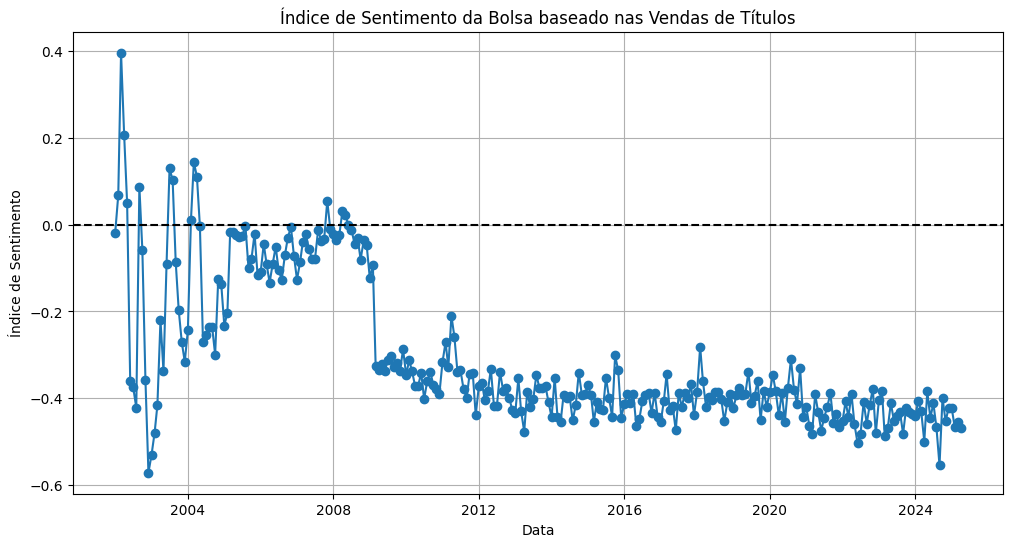

In [ ]:

grupo = grupo.reset_index()

# Criar o √≠ndice de sentimento
# F√≥rmula: (Venda_Otimismo - Venda_Medo) / (Venda_Otimismo + Venda_Medo)
grupo['Indice_Sentimento'] = (grupo['Venda_Otimismo'] - grupo['Venda_Medo']) / (grupo['Venda_Otimismo'] + grupo['Venda_Medo'])

# 9. Plotar
plt.figure(figsize=(12,6))
plt.plot(grupo['Data Venda'].dt.to_timestamp(), grupo['Indice_Sentimento'], marker='o')
plt.axhline(0, color='black', linestyle='--')
plt.title('√çndice de Sentimento da Bolsa baseado nas Vendas de T√≠tulos')
plt.xlabel('Data')
plt.ylabel('√çndice de Sentimento')
plt.grid(True)
plt.show()

In [24]:
import pandas as pd

# 1. Carregar o dataframe
df = pd.read_csv('data/VendasTesouroDireto.csv')

# 2. Ajustar datas
df['Data Venda'] = pd.to_datetime(df['Data Venda'], dayfirst=True, errors='coerce')

# 3. Filtrar os tipos relevantes
def identificar_tipo(titulo):
    if 'Prefixado' in titulo:
        return 'LTN'
    elif 'IPCA+' in titulo:
        return 'NTN-B'
    elif 'Selic' in titulo:
        return 'LFT'
    else:
        return 'OUTROS'

df['Tipo Simplificado'] = df['Tipo Titulo'].apply(identificar_tipo)

# 4. Agrupar por data e tipo
pivot = df.pivot_table(index='Data Venda', 
                       columns='Tipo Simplificado', 
                       values='Valor', 
                       aggfunc='sum').fillna(0)

# 5. Calcular o volume total
pivot['Total'] = pivot.sum(axis=1)

# 6. Aplicar a f√≥rmula
pivot['Indice Sentimento'] = (pivot.get('LTN', 0) - (pivot.get('NTN-B', 0) + pivot.get('LFT', 0))) / pivot['Total']

# 7. Mostrar o resultado
print(pivot[['Indice Sentimento']])


Tipo Simplificado  Indice Sentimento
Data Venda                          
2002-01-04                  0.000000
2002-01-07                  0.853846
2002-01-08                  0.651822
2002-01-09                  0.848101
2002-01-10                  0.882979
...                              ...
2025-04-17                  0.154655
2025-04-22                  0.081798
2025-04-23                  0.056371
2025-04-24                  0.002554
2025-04-25                 -0.004829

[5761 rows x 1 columns]


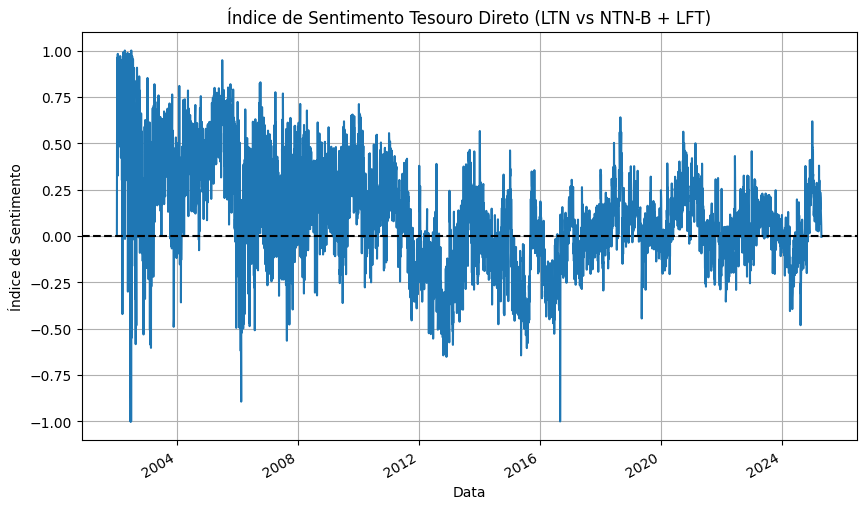

In [25]:
import matplotlib.pyplot as plt

pivot['Indice Sentimento'].plot(figsize=(10,6), title='√çndice de Sentimento Tesouro Direto (LTN vs NTN-B + LFT)')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('√çndice de Sentimento')
plt.xlabel('Data')
plt.grid(True)
plt.show()
